You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


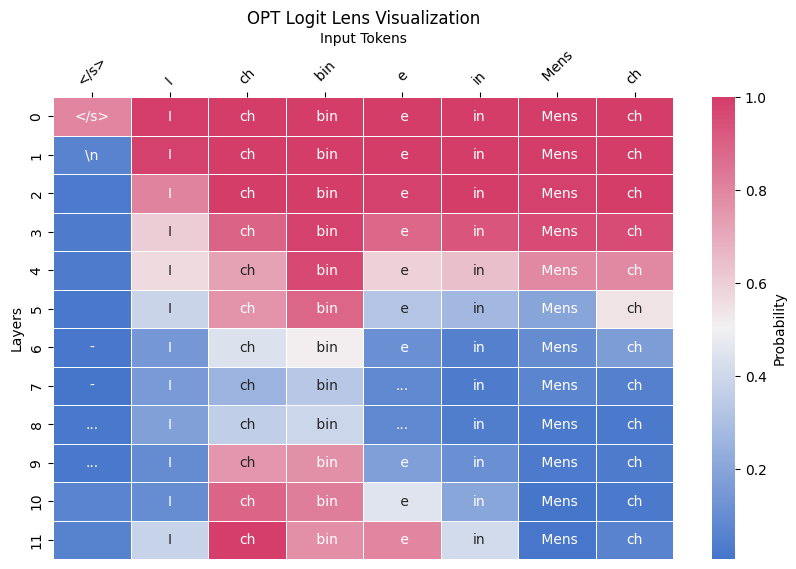

In [8]:
from nnsight import LanguageModel
from typing import List, Callable
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.display import clear_output

clear_output()

# OPT Modell laden (kleiner als GPT-2)
model = LanguageModel("facebook/opt-125m", device_map="auto", dispatch=True)

prompt = "Ich bin ein Mensch"
layers = model.model.decoder.layers  # OPT verwendet decoder.layers
probs_layers = []

with model.trace() as tracer:
    with tracer.invoke(prompt) as invoker:
        # Initialer Hidden State
        hidden_states = model.model.decoder.embed_tokens(invoker.inputs[0]["input_ids"]).save()
        
        for layer_idx, layer in enumerate(layers):
            # Layer-Verarbeitung
            outputs = layer(hidden_states)
            hidden_states = outputs[0].save()
            
            # Normalisierung und Projektion
            normalized = model.model.decoder.final_layer_norm(hidden_states)
            logits = model.lm_head(normalized)
            
            # Wahrscheinlichkeiten berechnen
            probs = torch.nn.functional.softmax(logits, dim=-1).save()
            probs_layers.append(probs)

# Wahrscheinlichkeiten zusammenfügen
probs = torch.stack([p.value[0] for p in probs_layers])

# Maximum Wahrscheinlichkeiten und Token-IDs finden
max_probs, tokens = probs.max(dim=-1)

# Token-IDs in Wörter umwandeln
words = [[model.tokenizer.decode(t).encode("unicode_escape").decode() for t in layer_tokens]
    for layer_tokens in tokens]

# Input-Wörter erhalten
input_words = [model.tokenizer.decode(t) for t in invoker.inputs[0]["input_ids"][0]]

# Visualisierung
output_words = input_words[1:] + ["?"]
cmap = sns.diverging_palette(255, 0, n=len(words[0]), as_cmap=True)

plt.figure(figsize=(10, 6))
ax = sns.heatmap(max_probs.cpu().detach().numpy(), 
                 annot=np.array(words), 
                 fmt='', 
                 cmap=cmap, 
                 linewidths=.5, 
                 cbar_kws={'label': 'Probability'})

plt.title('OPT Logit Lens Visualization')
plt.xlabel('Input Tokens')
plt.ylabel('Layers')

plt.yticks(np.arange(len(words)) + 0.5, range(len(words)))

plt.gca().xaxis.tick_top()
plt.gca().xaxis.set_label_position("top")
plt.xticks(np.arange(len(input_words)) + 0.5, input_words, rotation=45)

plt.show()